# 🪡 Forward Design Inflation with Tracking, Export, and Video Recording

In [1]:

import sys; sys.path.append('..')
import inflation, mesh, sheet_meshing
import triangulation, utils, py_newton_optimizer, benchmark
from tri_mesh_viewer import TriMeshViewer as Viewer
from tri_mesh_viewer import OffscreenTriMeshViewer
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import KDTree


In [2]:

# Load base geometry and create inflatable sheet
V, E = mesh.load_raw('data/ForwardDesign/hinge.obj')
fusedPts = list(np.loadtxt('data/ForwardDesign/fusehingev3.txt').reshape((-1, 2)))
holePts = []  # no holes

m, iwv, iwbv = sheet_meshing.forward_design_mesh(V, E, fusedPts, holePts,
    np.prod(utils.bbox_dims(V)[0:2]) / 1e4)
isheet = inflation.InflatableSheet(m, iwv)


In [3]:

# Define target points in rest configuration to track
target_points = np.array([
    [5.0,  0.0, 0.0],
    [5.0, 20.0, 0.0],
    [5.0, 40.0, 0.0]
])

# Map those to closest mesh vertices
V_rest = np.array([v.flatten() for v in isheet.restWallVertexPositions()])
tree = KDTree(V_rest)
tracked_indices = [tree.query(p)[1] for p in target_points]

# Prepare to store trajectories
trajectory = {idx: [] for idx in tracked_indices}
framerate = 5  # save every 5 iterations


In [4]:

# Live viewer
viewer = Viewer(isheet, wireframe=True)
viewer.show()

# Offscreen viewer for recording
oview = OffscreenTriMeshViewer(isheet, width=768, height=640, wireframe=True)

# Callback function: updates viewers and records position data
def cb(it):
    if it % framerate == 0:
        for idx in tracked_indices:
            pos = isheet.getDeformedVtxPosition(idx, 0).flatten()
            trajectory[idx].append(pos)
        viewer.update()


In [5]:

# Run the inflation simulation and record to video
benchmark.reset()
isheet.setUseTensionFieldEnergy(True)
isheet.setUseHessianProjectedEnergy(False)

opts = py_newton_optimizer.NewtonOptimizerOptions()
opts.niter = 500
isheet.pressure = 1.0

oview.recordStart('tracked_inflationALL2.mp4')
cr = inflation.inflation_newton(isheet, isheet.rigidMotionPinVars, opts, callback=cb)
benchmark.report()
oview.recordStop()


InflatableSheet setVars	0.0152519	1
Newton iterations	78.1221	1
    InflatableSheet energy	0.00049305	1
    Newton iterate	78.1211	115
        Backtracking	0.552209	114
            InflatableSheet energy	0.0985761	170
            InflatableSheet setVars	0.444941	170
        Compute descent direction	75.6298	114
            Negative curvature dir	0.193135	3
                negativeCurvatureDirection	0.186412	3
                    CHOLMOD Backsub	0.127852	51
                    CHOLMOD Numeric Factorize	0.00317788	3
                    CHOLMOD Symbolic Factorize	0.0313439	3
            newton_step	75.4357	114
                Newton solve	72.4534	194
                    CHOLMOD Numeric Factorize	70.4788	193
                    Solve	1.16631	115
                        CHOLMOD Backsub	0.983757	114
                        CHOLMOD Numeric Factorize	0.0280142	1
                        CHOLMOD Symbolic Factorize	0.138558	1
                hessEval	2.85162	114
                largestMagnitudeEi

In [6]:

# Export final inflated mesh
def write_obj(path, V, F):
    with open(path, "w") as f:
        for v in V:
            f.write("v {:.6f} {:.6f} {:.6f}\n".format(*v))
        for face in F:
            f.write("f {} {} {}\n".format(*(face + 1)))

# Extract geometry
V_final, F_final, _ = isheet.visualizationGeometry()
V = np.array([v.flatten() for v in V_final])
F = np.array([list(f) for f in F_final])

write_obj("inflated_scaledALL2.obj", V, F)


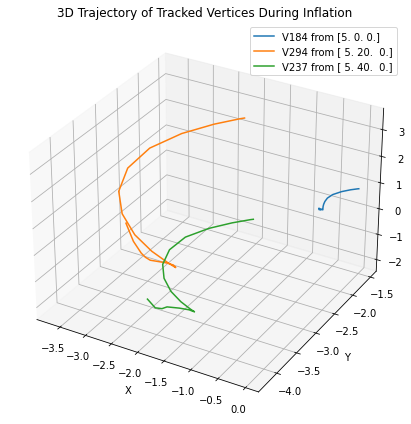

In [7]:

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for idx, point in zip(tracked_indices, target_points):
    traj = np.array(trajectory[idx])
    if traj.shape[0] <= 1:
        continue
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=f"V{idx} from {point}")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("3D Trajectory of Tracked Vertices During Inflation")
ax.legend()
plt.tight_layout()
plt.show()


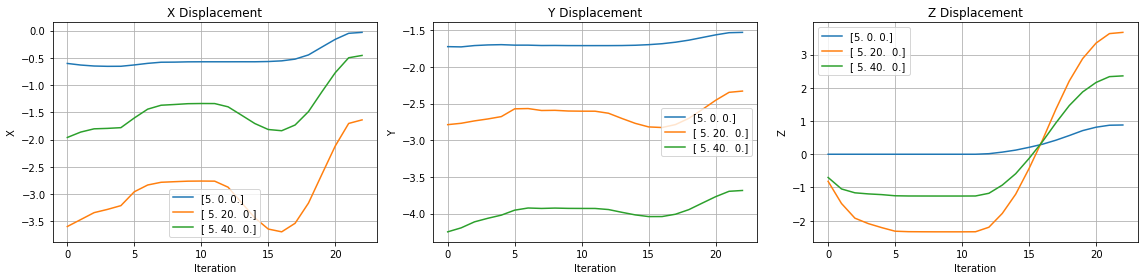

In [8]:

plt.figure(figsize=(16, 4))

# X
plt.subplot(1, 3, 1)
for idx, point in zip(tracked_indices, target_points):
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        plt.plot(range(len(traj)), traj[:, 0], label=f"{point}")
plt.title("X Displacement")
plt.xlabel("Iteration"); plt.ylabel("X"); plt.grid(True); plt.legend()

# Y
plt.subplot(1, 3, 2)
for idx, point in zip(tracked_indices, target_points):
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        plt.plot(range(len(traj)), traj[:, 1], label=f"{point}")
plt.title("Y Displacement")
plt.xlabel("Iteration"); plt.ylabel("Y"); plt.grid(True); plt.legend()

# Z
plt.subplot(1, 3, 3)
for idx, point in zip(tracked_indices, target_points):
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        plt.plot(range(len(traj)), traj[:, 2], label=f"{point}")
plt.title("Z Displacement")
plt.xlabel("Iteration"); plt.ylabel("Z"); plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()
